# MAP 554 - Lab 7: Machine learning for modeling - application on an aerospace problem

### Objectives:
This notebook is written as an introduction to application of Machine Learning tools in an engineering aerospace test case.

The objectives are to apply three Machine Learning (ML) tools for regression using scikit-learn python library:
- Artificial Neuron Network
- Support Vector Regression
- Gaussian Process

and to follow the general steps of ML for regression:
- Step 1: generation of Design of Experiment
- Step 2: creation of a surrogate model
- Step 3: training of the surrogate model
- Step 4: validation of the surrogate model
- Step 5: use of the surrogate model



In [9]:
# Support for maths
import numpy as np

# Plotting tools
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
from IPython.display import Image

# Machine learning library
import sklearn

# Install PyDoE package for design of experiment
#!pip install pyDOE2

from pyDOE2 import lhs

## Introduction

Aerodynamic assessment on winged configuration of Reusable Launch Vehicle is quite complex and requires time costly simulation code.

In this notebook, we will try to mimic the aerodynamic assessment of winged RLV concept that uses lifting surface in order to return to launch site in gliding mode.

Only the first stage of the RLV is considered here. 

The mission of the first stage is illustrated in the following figure : 




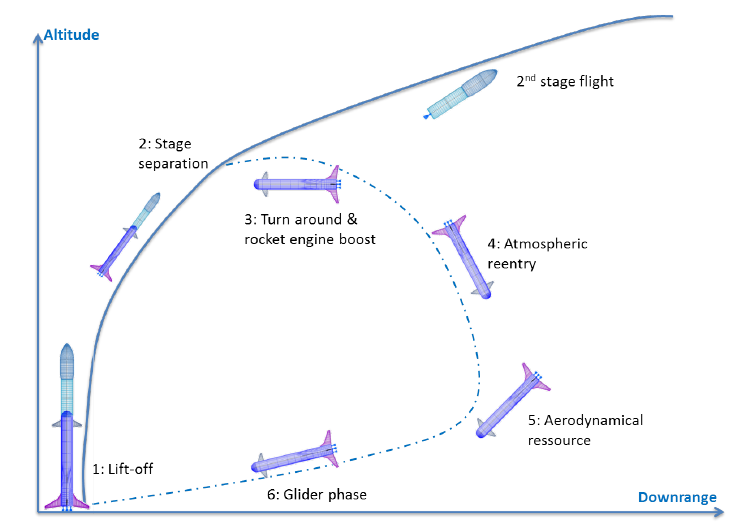

In [10]:
Image("illlustration_mission.png")

Ref: Balesdent, M., Brevault, L., Paluch, B., Wuilbercq, R., Subra, N., Thépot, R., & de Mirand, A. P.. Design and optimization of glide-back reusable launch vehicle architectures. European Conference on Aeronautic and Space Sciences, 2019, Madrid


The configuration under study is represented below (nozzles are not considered for the aerodynamic analysis) :

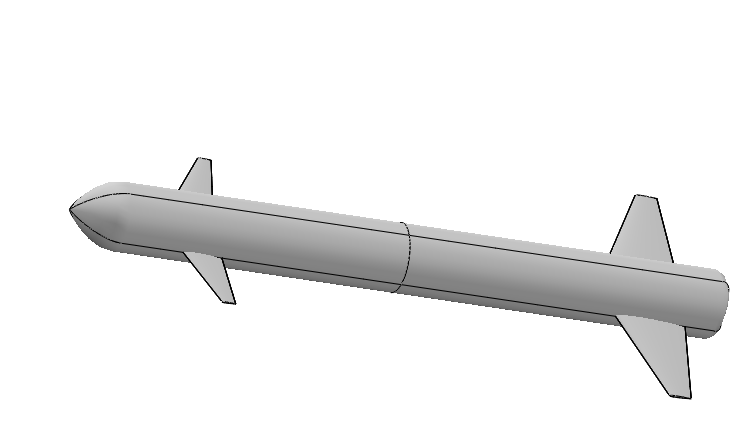

In [11]:
Image("RLV-gliding.png")

Especially, we will try to assess the aerodynamic performance of such a configuration with respect to the planform characteristics of the lifting surfaces (wings and canards).


## Aerodynamic parameterization

To assess the aerodynamic performance, aerodynamic calculations in subsonic mode have been performed using `NASA VSPAERO` software [http://openvsp.org/ ] to estimate the lift coefficient in the glider phase.

The 6 design variables that are consideed are:
- root chord of the wings,
- tip chord of the wings,
- sweep angle of the wings,
- root chord of the canards,
- tip chord of the canards,
- sweep angle of the canards.



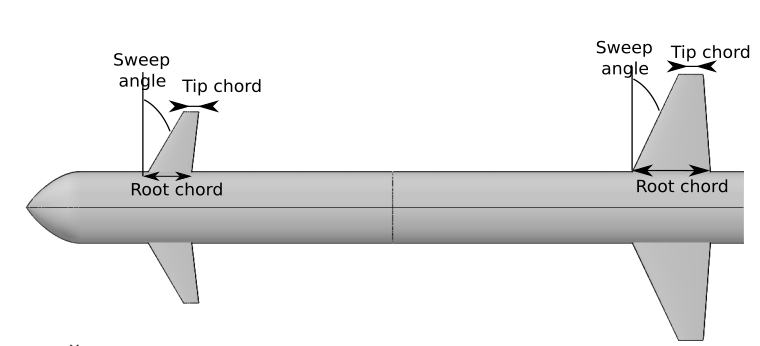

In [12]:
Image("parameterization.png")

The total areas of the wings and canards are supposed to be constant so the span of the elements are adapted from the design variables.

Dozens of simulations have been performed for various types of lifting surface configurations. Pressure fields of several configurations are illustrated in the next figure.



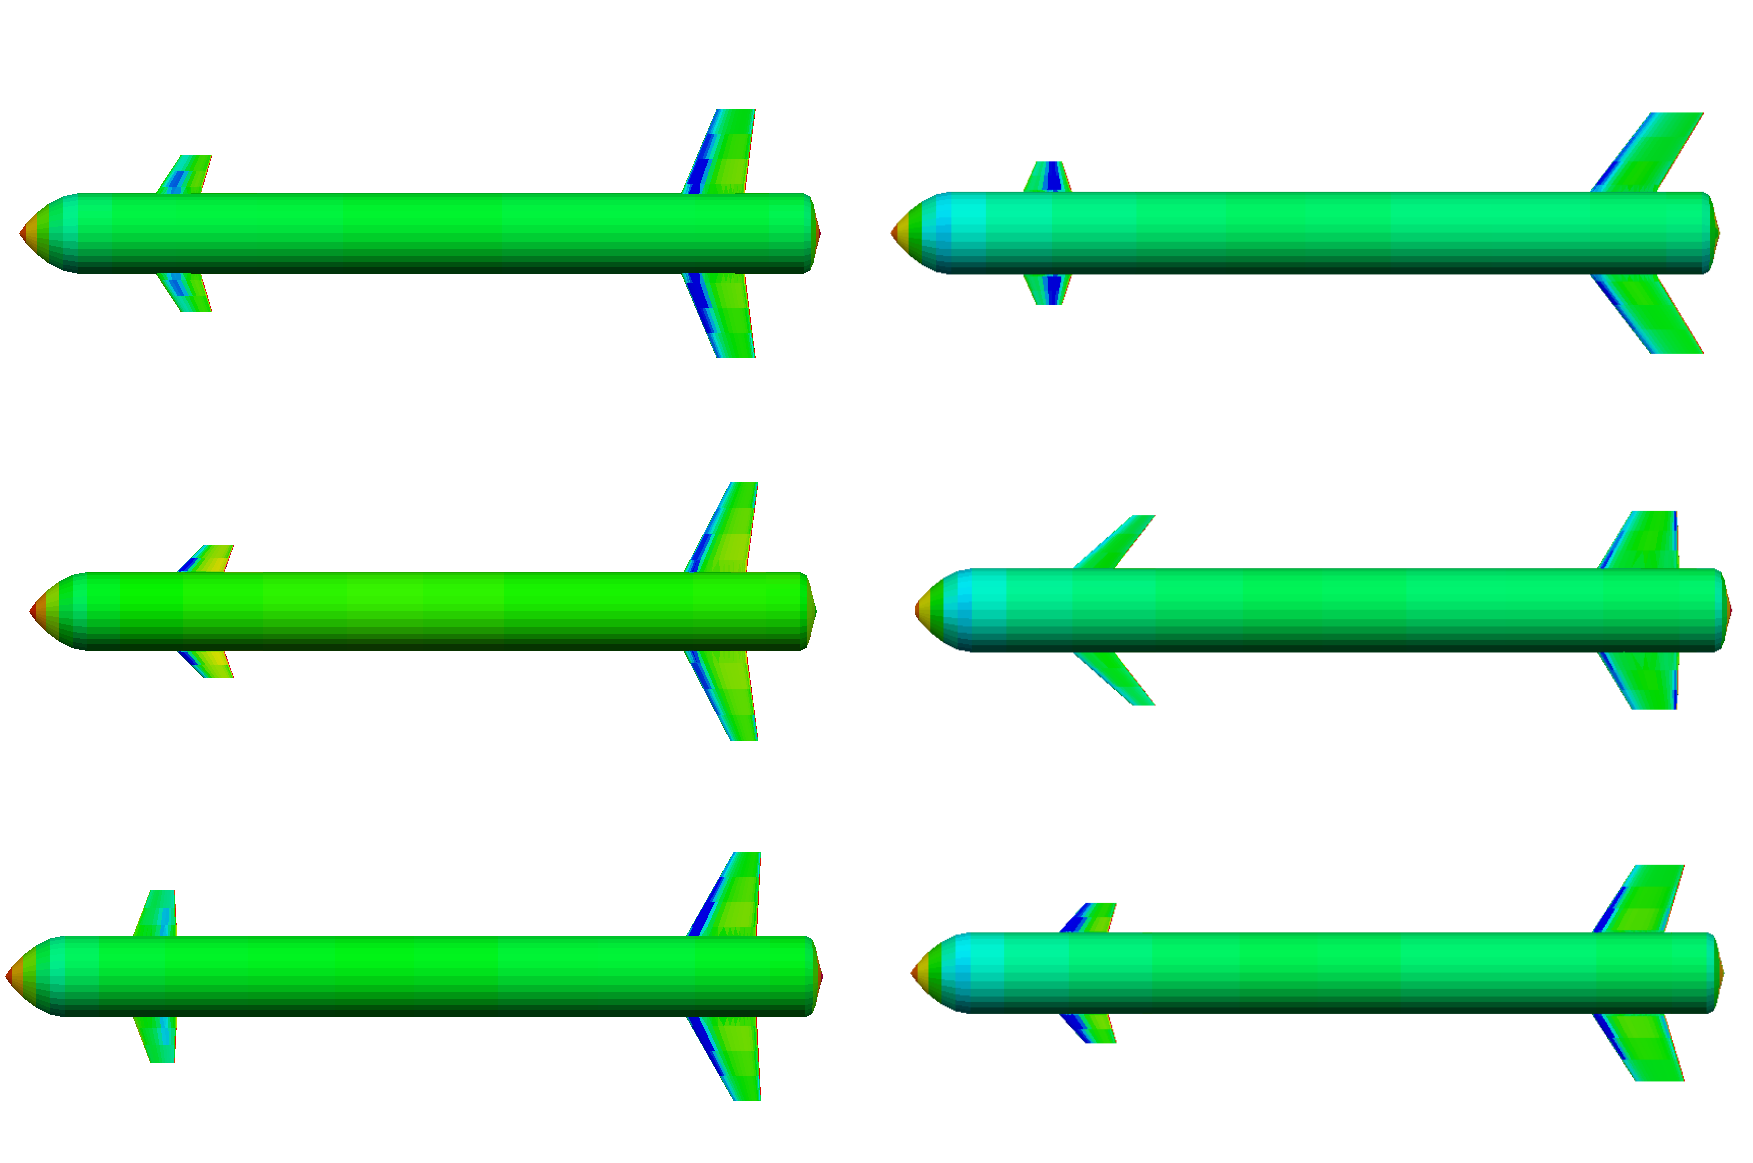

In [13]:
Image("CFD_cal.png")

## Surrogate modeling

In this Lab, we are trying to implement, test and compare different ML models to approximate the lift coefficient as a function of the design variables described above. 

The first task is to load the CFD data that are contained in a pickle archive : 'data_vlm.p'.

In [14]:
#Loading data
data = pickle.load(open('data_vlm.p','rb'))
# Keys of the dictionary
print(data.keys())

dict_keys(['data_set', 'test_set'])


In [15]:
#Copy of data
data_set = data['data_set']
print('Keys of training set dictionary:',data_set.keys())
test_set = data['test_set']
print('Keys of test set dictionary:',test_set.keys())

Keys of training set dictionary: dict_keys(['x', 'y'])
Keys of test set dictionary: dict_keys(['x', 'y'])


In [19]:
print("Size of the training set : {}".format(data_set['y'].shape[0]))
print("Size of the testing set : {}".format(test_set['y'].shape[0]))

Size of the training set : 59
Size of the testing set : 100


## Questions:

*   Using the data_set and the test_set compare ML models (ANN, SVR and GP) with respect to the RMSE,
*   Try differents settings for the ML models (kernels, setting parameters, etc.) to improve the RMSE of the different techniques, 
*   For the Gaussian Process, provide a confidence interval on the prediction for the data of the test set.



In [34]:
# getting data
X_train=data_set['x']
Y_train=data_set['y']
X_test=test_set['x']
Y_test=test_set['y']

def get_sqrt_MSE(y_test,y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [78]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

        
nb_units_list = [10,15,20,25,30]
nb_layers_list = [2,3,4,5]
#act_fns = ['relu','logistic','tanh']
act_fns = ['logistic']

for nb_units in nb_units_list:
    for nb_layers in nb_layers_list:
        for act_fn in act_fns:
    
            layers = []
            for k in range(nb_layers):
                layers.append(nb_units)
            regr = MLPRegressor(hidden_layer_sizes = tuple(layers), activation=act_fn,
                                solver='adam',max_iter=5000)

            regr.fit(X_train,Y_train)  # Training of the MLP

        
            y_pred = regr.predict(X_test) # for MLP

            print("MLP error for {} layers with {} neurons per layer and {} act fn : {} ".format(nb_layers,nb_units,act_fn,get_sqrt_MSE(Y_test,y_pred))) 

MLP error for 2 layers with 10 neurons per layer and logistic act fn : 0.06181349091465653 
MLP error for 3 layers with 10 neurons per layer and logistic act fn : 0.06937743672416646 
MLP error for 4 layers with 10 neurons per layer and logistic act fn : 0.06062062682479989 
MLP error for 5 layers with 10 neurons per layer and logistic act fn : 0.06070170913794644 
MLP error for 2 layers with 15 neurons per layer and logistic act fn : 0.0640453567689499 
MLP error for 3 layers with 15 neurons per layer and logistic act fn : 0.05785629342070827 
MLP error for 4 layers with 15 neurons per layer and logistic act fn : 0.057496888714512744 
MLP error for 5 layers with 15 neurons per layer and logistic act fn : 0.061979974525432795 
MLP error for 2 layers with 20 neurons per layer and logistic act fn : 0.07224048020662319 
MLP error for 3 layers with 20 neurons per layer and logistic act fn : 0.0730523001216416 
MLP error for 4 layers with 20 neurons per layer and logistic act fn : 0.0576653

In [74]:
from sklearn.svm import SVR


## Here modify the settings of SVR and study their influences on the RMSE

C_list = [1e5,1e6,1e7]
list_kernels = ['linear', 'rbf', 'sigmoid']

for C in C_list:
    for kernel in list_kernels:
        
        regr = SVR(kernel=kernel,C=C,tol=1e-6, epsilon=0.01) # diminished epsilon because we are expecting a drag coeff of roughly 0.5-0.8

        regr.fit(X_train,Y_train)  # Training of the MLP

        y_pred = regr.predict(X_test) 

        print("MLP error for C = {} and a {} kernel : {} ".format(C,kernel,get_sqrt_MSE(Y_test,y_pred))) 

MLP error for C = 100000.0 and a linear kernel : 13.617389260707546 
MLP error for C = 100000.0 and a rbf kernel : 0.01039871154389156 
MLP error for C = 100000.0 and a sigmoid kernel : 54235.988933004606 
MLP error for C = 1000000.0 and a linear kernel : 252.01966298753646 
MLP error for C = 1000000.0 and a rbf kernel : 0.01039871154389156 
MLP error for C = 1000000.0 and a sigmoid kernel : 542359.617251034 
MLP error for C = 10000000.0 and a linear kernel : 1360.7346352930656 
MLP error for C = 10000000.0 and a rbf kernel : 0.01039871154389156 
MLP error for C = 10000000.0 and a sigmoid kernel : 5423595.900431561 


In [76]:
from sklearn.gaussian_process.kernels import RBF,Matern
from sklearn.gaussian_process import GaussianProcessRegressor



kernel_Matern_5 = 1.0*Matern(length_scale=1.0, nu=1.5)
kernel_rbf = 1.0*RBF(length_scale=1.0)
kernel_Matern_3 = 1.0*Matern(length_scale=1.0, nu=2.5)


list_kernels = [kernel_Matern_5,kernel_rbf, kernel_Matern_3]
for kernel in list_kernels:


    regr = GaussianProcessRegressor(kernel=kernel,random_state=0,
                               optimizer='fmin_l_bfgs_b',
                               n_restarts_optimizer=50)
    regr.fit(X_train,Y_train)  # Training of the MLP

    y_pred = regr.predict(X_test) # for MLP


    print("MLP error for a {} kernel : {} ".format(kernel,get_sqrt_MSE(Y_test,y_pred))) 

MLP error for a 1**2 * Matern(length_scale=1, nu=1.5) kernel : 0.00964321798683884 
MLP error for a 1**2 * RBF(length_scale=1) kernel : 0.019228593791427218 
MLP error for a 1**2 * Matern(length_scale=1, nu=2.5) kernel : 0.01167855928373326 
